# Part 0. Load Packages

**Natural Language Processing (NLP):** a branch of computer science (or more specifically, the branch of artificial intelligence or AI) concerned with giving computers the ability to understand text and spoken words in much the same way human beings can.

Reference: https://www.ibm.com/cloud/learn/natural-language-processing

Data Sorce (Amazon customer Review data on watch): https://snap.stanford.edu/data/web-Amazon.html

In [3]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
nltk.download('punkt') # punctuation
nltk.download('stopwords') # stopword

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Part 1. Setup Google Drive Environment and Load Data

In [6]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# https://drive.google.com/file/d/1x8BsmGs4AmkVfUfL_AiLsXt69UKEJTEo/view?usp=sharing
file = drive.CreateFile({'id':'1x8BsmGs4AmkVfUfL_AiLsXt69UKEJTEo'}) 
file.GetContentFile('watch_review.tsv') # tsv -> tab seperated values

In [8]:
review_data = pd.read_csv('watch_review.tsv', sep = '\t', error_bad_lines = False) 
# error_bad_lines = False: if errors occur while reading a line, skip this line.
# text are more complicated than values. 
# txt file is not able to be read like a table in a csv file, it may include emoji, ....

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkip

# Part 2. Data Preprocessing

In [9]:
review_data.shape

(960204, 15)

In [10]:
# Explore the raw data
review_data.head(10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31
5,US,6576411,RA51CP8TR5A2L,B00EYSOSE8,230493695,Casio Men's GW-9400BJ-1JF G-Shock Master of G ...,Watches,5,0,0,N,Y,No complaints,"i love this watch for my purpose, about the pe...",2015-08-31
6,US,11811565,RB2Q7DLDN6TH6,B00WM0QA3M,549298279,Fossil Women's ES3851 Urban Traveler Multifunc...,Watches,5,1,1,N,Y,Five Stars,"for my wife and she loved it, looks great and ...",2015-08-31
7,US,49401598,R2RHFJV0UYBK3Y,B00A4EYBR0,844009113,INFANTRY Mens Night Vision Analog Quartz Wrist...,Watches,1,1,5,N,N,I was about to buy this thinking it was a ...,I was about to buy this thinking it was a Swis...,2015-08-31
8,US,45925069,R2Z6JOQ94LFHEP,B00MAMPGGE,263720892,G-Shock Men's Grey Sport Watch,Watches,5,1,2,N,Y,Perfect watch!,Watch is perfect. Rugged with the metal &#34;B...,2015-08-31
9,US,44751341,RX27XIIWY5JPB,B004LBPB7Q,124278407,Heiden Quad Watch Winder in Black Leather,Watches,4,0,0,N,Y,Great quality and build,Great quality and build.<br />The motors are r...,2015-08-31


In [11]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960197 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


## 2.1 Check Missing Data

In [12]:
review_data.isna().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          2
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline        7
review_body          148
review_date            4
dtype: int64

In [13]:
# Drop missing data in 'review_body' column
review_data.dropna(subset = ['review_body'], inplace = True)

In [14]:
review_data.reset_index(inplace = True, drop = True)

In [15]:
review_data.shape

(960056, 15)

In [16]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960056 entries, 0 to 960055
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960056 non-null  object
 1   customer_id        960056 non-null  int64 
 2   review_id          960056 non-null  object
 3   product_id         960056 non-null  object
 4   product_parent     960056 non-null  int64 
 5   product_title      960054 non-null  object
 6   product_category   960056 non-null  object
 7   star_rating        960056 non-null  int64 
 8   helpful_votes      960056 non-null  int64 
 9   total_votes        960056 non-null  int64 
 10  vine               960056 non-null  object
 11  verified_purchase  960056 non-null  object
 12  review_headline    960049 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960052 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


# Part 3. Data Spliting

Use the all rows as training data.

Only use each review_body (a review_body = a document).

In [17]:
train = review_data.loc[:, 'review_body'].tolist()

In [18]:
len(train)

960056

In [19]:
# Check for the review in the training data.
# Every review is considered as a document.
train[:9]

['Absolutely love this watch! Get compliments almost every time I wear it. Dainty.',
 'I love this watch it keeps time wonderfully.',
 'Scratches',
 'It works well on me. However, I found cheaper prices in other places after making the purchase',
 "Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch",
 'i love this watch for my purpose, about the people complaining should of done their research better before buying. dumb people.',
 'for my wife and she loved it, looks great and a 

# Part 4. Tokenizing and Stemming

**Tokenizing**: a process of splitting a text into individual words or sequences of words. 

For example, we only have two reviews/documents:

    'I like this product' --> [I, NaN, like, this, product]

    'I don't like this product' --> [I, don't, like, this, product]

Now we have 5 unique word/feature. In NLP, the feature set is called a dictionary: 

              feature1   feature2   feature3   feature4   feature5
    dictionary: [I,      don't,     like,      this,      product]

**N-grams**: continuous sequences of words or symbols or tokens in a document.

     Document 1: 'I like this product'
     1 - gram: [I, like, this, product]
     2 - gram: [I like, like this, this product]
     3 - gram: [I like this, like this product]


Feature Set:

              feature1   feature2   feature3   feature4   feature5
    Dictionary = [I,     don't,     like,      this,      product]

     'I like this product'
     [1, 0, 1, 1, 1]

     'I don't like this product'
     [1, 1, 1, 1, 1]




**Stemming**: a process of counting inflected forms of a word together. It helps reducing the number of unique vocabulary items that we neet to track.

For example:

      girls --> girl
      programmers --> program
      likes --> like
      liked --> like
      likely --> like
      liking --> like


**Stop words**: words that do not convey significant meaning. (i.e., a, an, the, this, that, it)


Usually, after we do document tokenization, we remove the stop words. Here, I use nltk's English stopwords. NLTK is a library, the full name is Natural Language Toolkit, and it includes 153 stop words in English.

There is a disadvantage here: if a word, (for example, 'like') occurs many time in a review/document, it only record 1 and does not indicate the importance of the word 'like' in this document. Therefore, we can use TF-IDF to solve this problem.

In [20]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") # b/c of the html <br>
stopwords.append("watch") # b/c this is reviews for watch

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [21]:
stemmer = SnowballStemmer("english")

# Function for tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []

    # First step:
    # If word is not in stopword, then it is important, add it to tokens.
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # Second step:
    # Drop any tokens not containing letters such as numeric tokens, punctuation, emoji
    for token in tokens:
        if token.isalpha(): # isalpha(): if it is a alphabetic letter
            filtered_tokens.append(token)
            
    # Do stemming for each token
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [22]:
# Run a small test
train[0]

'Absolutely love this watch! Get compliments almost every time I wear it. Dainty.'

In [23]:
tokenization_and_stemming(train[0])

['absolut',
 'love',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'wear',
 'dainti']

# Part 5. Term Frequency - Inverse Document Frequency (TF-IDF)

**Why TF-IDF?**

TF-IDF can provide the weighting factor to indicate the importance of a word in a collection of reviews/documents. TF-IDF is applied on about 83% text-based recommendation system. 

**Definition of TF-IDF:**

Corpus: the total amount of documents in the data set.

- TF(wordA_in_docB) = count of wordA in docB / total word counts in docB

- IDF(wordA) = log(total number of documents in the corpus/number of documents where wordA appears)

Use log in IDF to transform a very large number to a smaller number. Because a corpus may have many documents, we can transform the IDF to smaller number for better calculation.

- TF-IDF(wordA_in_docB) = TF(wordA_in_docB)*IDF(wordA)

For example:


document 1: 'I like this product'

document 2: 'I don't like this product'

Corpus = 1; Using 1-gram.

Feature sets: 

dictionary = [I, don't, like, this, product]

     TF: 
          document 1:
                     TF('I', document 1) = 1/4
                     TF('like', document 1) = 1/4
                     TF('this', document 1) = 1/4
                     TF('product', document 1) = 1/4

          document 2:
                     TF('I', document 1) = 1/5
                     TF('don't', document 1) = 1/5
                     TF('like', document 1) = 1/5
                     TF('this', document 1) = 1/5
                     TF('product', document 1) = 1/5

      IDF:
                     IDF('I', Corpus) = log(2/2)
                     IDF('don't', Corpus) = log(2/1)
                     IDF('like', Corpus) = log(2/2)
                     IDF('this', Corpus) = log(2/2)
                     IDF('product', Corpus) = log(2/2)


       TF-IDF: 
                    TF-IDF('I', document 1, Corpus) = TF('I', document 1) * IDF('I', Corpus) = 1/4 * log(2/2) = 0
                    TF-IDF('like', document 1, Corpus) = TF('like', document 1) = 1/4 * log(2/1) = 0.075257



            




**TfidfVectorizer** will help us to create tf-idf matrix

**max_df** : maximum document frequency for the given word

**min_df** : minimum document frequency for the given word

**max_features**: maximum number of words

**use_idf**: if not true, we only calculate tf

s**top_words** : built-in stop words

**tokenizer**: how to tokenize the document

**ngram_range**: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram

In [24]:
tfidf_model = TfidfVectorizer(max_df = 0.99, max_features = 1000, min_df = 0.01, stop_words = stopwords,
                                 use_idf = True, tokenizer = tokenization_and_stemming, ngram_range = (1, 1))

# fit the vectorizer to synopses
tfidf_matrix = tfidf_model.fit_transform(train) 

print ("There are " + str(tfidf_matrix.shape[0]) + " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


There are 960056 reviews and 404 terms.


In [25]:
tfidf_matrix

<960056x404 sparse matrix of type '<class 'numpy.float64'>'
	with 12395791 stored elements in Compressed Sparse Row format>

Print out the TF-IDF matrix for each document. It represents the weight for each word.

In [26]:
print(tfidf_matrix.toarray())
print(type(tfidf_matrix.toarray()))

[[0.         0.45050746 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'>


In [27]:
print(tfidf_matrix.todense())
print(type(tfidf_matrix.todense()))

[[0.         0.45050746 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.matrix'>


In [29]:
tf_selected = tfidf_model.get_feature_names()
tf_selected[:9]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abl',
 'absolut',
 'accur',
 'actual',
 'adjust',
 'ago',
 'alarm',
 'almost',
 'alreadi']

# Part 6. K-means Clustering

K-means: an unsupervised learning algorithm to partition n observations into k (<= n) sets so as to miimize the within-cluster sum of squares.

Randomly create two grey points. These two points are newly created; they are not from the existing data points. 


First, for each grey point, calculate the distances from each existing data point to the grey point. Then, the grey point x will move to the center (centroid) of its closest existing data points (A, B) and the grey point y will move to the center of its closest existing data points (C, D, E). 


Then, after moving the their new location,again, for each grey point, calculate the distances from each existing data point to the grey point. And then grey points move to the center of their closest points.


Finally, when two points stay in the same location, K-means algorithm gives us two clusters.

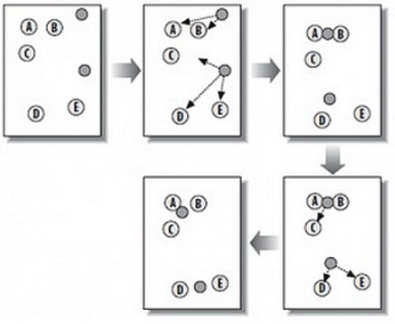

**Pseudo Code:**

inertia value: (smaller, better) measure how well a dataset was clustered by K-means. It is calculated by measureing the distance between each data point and its centroid, squaring this distance, and summing these suqres across one cluster. 

|a(k) - a(k - 1)| < tolerance

     for k-means multiple times (n_init = 10):
         reset centroids
         while run times < max_iter and cur_tol > tol:
             execute steps in feature above
          calculate inertia value
     choose the k-means result with the best inertia value

In [30]:
num_clusters = 5

kmc = KMeans(n_clusters = num_clusters)
kmc.fit(tfidf_matrix)

clusters = kmc.labels_.tolist()

In [31]:
# Create DataFrame
review = {'review': review_data.review_body, 'cluster': clusters}
km_frame = pd.DataFrame(review, columns = ['review', 'cluster'])

In [32]:
km_frame.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,1
1,I love this watch it keeps time wonderfully.,4
2,Scratches,1
3,"It works well on me. However, I found cheaper ...",1
4,Beautiful watch face. The band looks nice all...,1
5,"i love this watch for my purpose, about the pe...",1
6,"for my wife and she loved it, looks great and ...",0
7,I was about to buy this thinking it was a Swis...,1
8,Watch is perfect. Rugged with the metal &#34;B...,0
9,Great quality and build.<br />The motors are r...,0


The disadvantage of K-means:

The result of K-means clustering may be imbalanced. For example, in this case, cluster 0 is much larger than other clusters.

This disadvantage may affect our insights on the data.

In [33]:
# Number of reviews in each cluster
km_frame['cluster'].value_counts().to_frame()


,cluster
1,692100
0,111959
2,64809
4,55623
3,35565


In [34]:
# Find the cluster center
# kmc.cluster_centers_: importances of each items in centroid

# cluster center is the centroid of k-means clustering. (the grey points' final position)

print(kmc.cluster_centers_.shape)
print(kmc.cluster_centers_)

(5, 404)
[[0.00158438 0.00544124 0.00438511 ... 0.0022096  0.0091713  0.00349446]
 [0.0052306  0.00626683 0.00728809 ... 0.00430295 0.01905592 0.00615715]
 [0.0012034  0.00224281 0.00360559 ... 0.00144788 0.00438485 0.00312387]
 [0.0003235  0.00049332 0.00247701 ... 0.00046682 0.00251326 0.00118424]
 [0.00101186 0.02014002 0.0009192  ... 0.0008294  0.00849631 0.00252902]]


There are 353 features in TF-IDF (columns) and 5 clusters (rows) in total. 

Assumption: The value of the center point represents the cluster. If ti-idf value is large, then the corresponding word is more able to represent this document. Therefore, select the top 6 greatest values to represent each cluster.

In [35]:
# Print out the top 6 important words in each cluster

# Sort the kmc.cluster_centers_ in decreasing order to get the top 25 words
ordered_centroids = kmc.cluster_centers_.argsort()[:, ::-1] 

keywords = {} 

for i in range(num_clusters):
    print ("Cluster " + str(i) + ":", end = ' ')

    keywords[i] = []

    for idx in ordered_centroids[i, :25]:
        keywords[i].append(tf_selected[idx])
        print (tf_selected[idx] + ", ", end = '')
    print ()
    
    cluster_reviews = km_frame[km_frame.cluster == i].review.tolist()

    print ("Cluster " + str(i) + " has " + str(len(cluster_reviews)) + " reviews: ")
    print ()

Cluster 0: great, excel, look, price, product, love, work, qualiti, time, gift, recommend, buy, good, wear, like, well, band, valu, perfect, bought, purchas, beauti, would, fit, easi, 
Cluster 0 has 111959 reviews: 

Cluster 1: look, like, time, band, one, work, love, wear, would, good, get, beauti, use, perfect, wrist, price, well, realli, bought, face, day, purchas, buy, qualiti, year, 
Cluster 1 has 692100 reviews: 

Cluster 2: nice, look, price, love, realli, good, like, great, qualiti, band, gift, big, time, well, color, littl, work, wear, fit, would, wrist, size, bought, face, recommend, 
Cluster 2 has 64809 reviews: 

Cluster 3: good, product, price, look, qualiti, like, excel, work, time, recommend, buy, love, thank, realli, great, valu, nice, keep, expect, item, well, far, one, deal, band, 
Cluster 3 has 35565 reviews: 

Cluster 4: love, gift, beauti, bought, husband, wife, son, look, great, daughter, perfect, absolut, got, wear, color, thank, one, time, christma, realli, much

# Part 7. Topic Modeling - Latent Dirchlet Allocation

LDA is specifically for NLP. It is much like PCA or K-means. 

**Reference:** 

https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/

https://towardsdatascience.com/lda-topic-modeling-an-explanation-e184c90aadcd


https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

**Topic Modeling**: a statistical modeling for discovering the abstract "topics" that occur in a collection of documents (or, corpus).

**Latent Dirichlet Allocation** (LDA): one of the topic modeling and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In LDA, each document is asumed to be characterized by a particular set of topics. If observations are words collected into documents, LDA result means that: (1). Each document is a mixture of a small number of topics; (2). Each word's creation is attributable to one of the document's topic.

P(word|document) = ∑(P(word|topic) * P(topic|document)) (sum over topics)

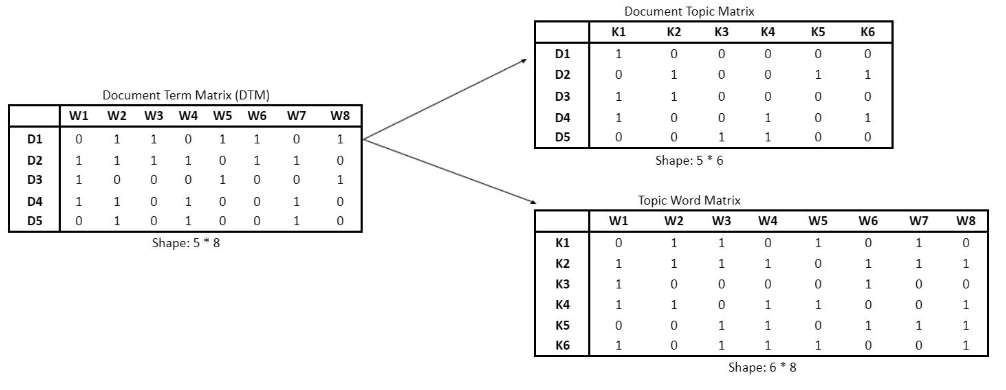

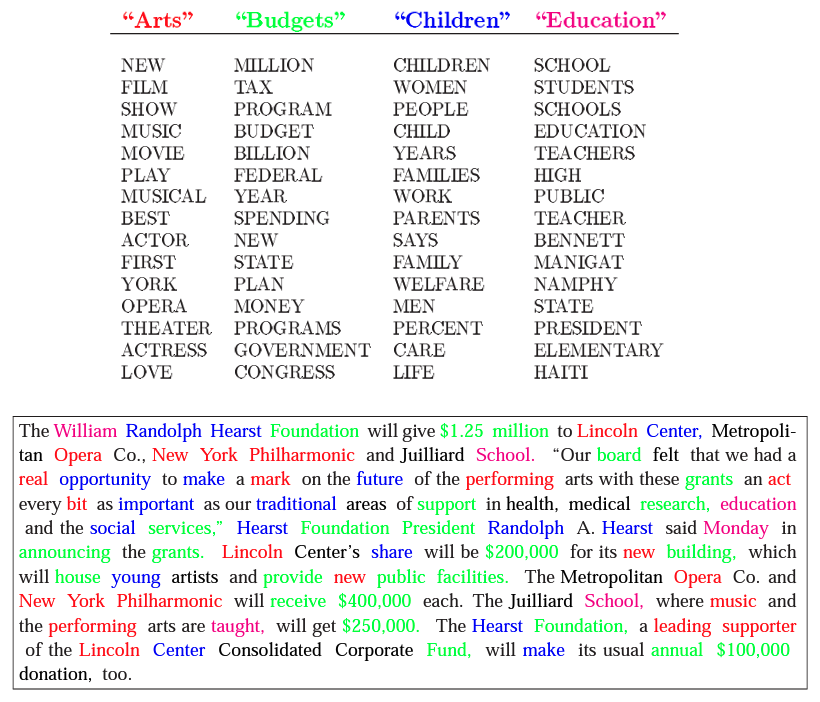

In [36]:
# Use LDA for clustering
# Set the topic numbers to 5
lda = LatentDirichletAllocation(n_components = 5)

In [37]:
# Document topic matrix for tfidf_matrix_lda
lda_result = lda.fit_transform(tfidf_matrix)
print(lda_result.shape)
print(lda_result)

(960056, 5)
[[0.0536699  0.05467903 0.05475189 0.5233063  0.31359289]
 [0.07196475 0.07174588 0.07007822 0.07264878 0.71356236]
 [0.10014005 0.59745081 0.10096993 0.10143919 0.10000002]
 ...
 [0.05213021 0.05256344 0.05267344 0.78960728 0.05302562]
 [0.05008728 0.79877472 0.05039082 0.05080697 0.04994021]
 [0.056133   0.77303822 0.05695273 0.05781324 0.0560628 ]]


Now we have 960,056 reviews and 5 topics.

In [38]:
# topics and features matrix
topic_feature_matrix = lda.components_
print(topic_feature_matrix.shape)
print(topic_feature_matrix)

(5, 404)
[[3.67984305e+01 8.57565560e+01 5.99390530e+01 ... 9.39058466e+01
  3.30279336e+01 6.35043084e+01]
 [2.27684980e+03 6.55290895e+02 3.38999895e+03 ... 1.60842443e+03
  9.11199652e+03 1.50623241e+03]
 [2.55505034e+02 1.05420146e+03 4.53007507e+02 ... 1.51019898e+03
  5.02957672e+02 1.05737278e+03]
 [1.37395298e+03 5.85259202e+02 1.72555025e+03 ... 1.70057296e+02
  4.61674122e+03 1.97181977e+03]
 [8.87939098e-01 3.85102975e+03 2.80011009e+02 ... 2.02192846e-01
  7.97096161e+02 4.39687981e+02]]


We have 5 topics and  404 features.

## 7.1 Topics & Documents

In [39]:
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]
review_names = ["Review " + str(i) for i in range(len(train))]

# Probability of being in Topic 0, Topic 1, ...
review_topic = pd.DataFrame(np.round(lda_result, 4), columns = topic_names, index = review_names)

# Print out the most possible topic for each document
topic = np.argmax(review_topic.values, axis = 1)
review_topic['topic'] = topic

review_topic.head(20)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Review 0,0.054,0.055,0.055,0.523,0.314,3
Review 1,0.072,0.072,0.070,0.073,0.714,4
Review 2,0.100,0.598,0.101,0.101,0.100,1
Review 3,0.055,0.781,0.054,0.055,0.055,1
Review 4,0.035,0.299,0.217,0.413,0.036,3
Review 5,0.075,0.074,0.700,0.074,0.077,2
Review 6,0.066,0.064,0.065,0.065,0.740,4
Review 7,0.058,0.058,0.770,0.057,0.056,2
Review 8,0.041,0.042,0.405,0.472,0.040,3
Review 9,0.062,0.763,0.058,0.058,0.059,1


Columns: topics; Rows: reviews/documents.

In [40]:
# It seems that it is quite balanced
review_topic['topic'].value_counts().to_frame()

,topic
1,289181
2,227298
3,173401
0,135728
4,134448


## 7.2 Topics & Features

In [41]:
# Print topic feature matrix
print(lda.components_)

# Convert topic feature dataframe
topic_feature_df = pd.DataFrame(lda.components_)


[[3.67984305e+01 8.57565560e+01 5.99390530e+01 ... 9.39058466e+01
  3.30279336e+01 6.35043084e+01]
 [2.27684980e+03 6.55290895e+02 3.38999895e+03 ... 1.60842443e+03
  9.11199652e+03 1.50623241e+03]
 [2.55505034e+02 1.05420146e+03 4.53007507e+02 ... 1.51019898e+03
  5.02957672e+02 1.05737278e+03]
 [1.37395298e+03 5.85259202e+02 1.72555025e+03 ... 1.70057296e+02
  4.61674122e+03 1.97181977e+03]
 [8.87939098e-01 3.85102975e+03 2.80011009e+02 ... 2.02192846e-01
  7.97096161e+02 4.39687981e+02]]


In [42]:
# Check features and topic
# The importance of each feature to each topic
topic_feature_df.columns = tfidf_model.get_feature_names()
topic_feature_df.index = topic_names

topic_feature_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abl,absolut,accur,actual,adjust,ago,alarm,almost,alreadi,also,although,alway,amaz,amazon,anoth,anyon,anyth,appear,arm,around,arriv,ask,attract,automat,away,awesom,back,bad,band,batteri,beat,beauti,believ,best,better,bezel,big,bigger,birthday,bit,black,blue,bought,box,bracelet,brand,break,bright,broke,broken,button,buy,ca,came,care,case,casio,casual,chang,charg,cheap,check,christma,citizen,clasp,classi,classic,clean,clear,clock,close,collect,color,come,comfort,comment,compani,compar,complaint,complet,compliment,condit,consid,cool,correct,cost,could,coupl,crown,crystal,custom,cute,daili,dark,date,daughter,day,deal,decid,definit,deliveri,describ,design,dial,differ,difficult,digit,direct,disappoint,display,dress,due,durabl,easi,easili,either,eleg,els,end,enjoy,enough,especi,even,ever,everi,everyday,everyth,exact,excel,except,expect,expens,extra,extrem,eye,face,fact,fair,far,fast,favorit,featur,feel,fell,figur,final,find,fine,finish,first,fit,fix,found,friend,function,gave,get,gift,give,glass,go,goe,gold,good,got,great,guess,hand,happi,hard,heavi,help,high,hold,hope,hour,howev,huge,husband,impress,includ,inexpens,insid,instead,instruct,invicta,issu,item,jewel,job,keep,kind,know,larg,larger,last,least,leather,less,let,life,light,like,line,link,littl,long,longer,look,loos,lost,lot,love,low,made,make,man,mani,manual,match,materi,may,mayb,mean,mechan,men,metal,might,mine,minut,model,money,month,move,movement,much,must,need,never,new,next,nice,night,normal,noth,notic,number,ok,old,one,open,order,origin,otherwis,overal,packag,paid,part,pay,peopl,perfect,person,pictur,piec,pin,place,plastic,pleas,plus,point,poor,present,pretti,price,probabl,problem,product,purchas,put,qualiti,quick,quit,rate,rather,read,real,realli,reason,receiv,recommend,remov,repair,replac,resist,return,review,right,rubber,run,said,satisfi,save,saw,say,scratch,second,see,seem,seen,seiko,seller,send,sent,servic,set,sever,ship,short,show,side,silver,similar,simpl,sinc,size,slight,small,smaller,solar,solid,someon,someth,son,sport,stainless,star,start,stay,steel,still,stop,store,strap,sturdi,style,stylish,super,sure,surpris,swiss,take,tell,thank,thick,thin,thing,think,though,thought,three,time,timepiec,timex,took,tool,top,total,tri,turn,two,type,uniqu,updat,use,usual,valu,wait,want,warranti,water,way,wear,week,weight,well,went,white,wife,wind,wish,within,without,wo,wonder,wore,work,worn,worri,worth,would,wrist,wrong,year,yet
Topic0,36.798,85.757,59.939,184.896,0.249,2.093,0.201,55.380,242.794,550.583,53.721,480.547,1285.175,3283.422,738.565,1160.007,94.991,395.655,0.213,80.021,5855.238,450.079,47.905,5.396,110.389,5866.225,220.927,1649.181,384.714,706.334,2.153,1929.004,214.485,659.276,1426.469,0.204,23.589,0.206,0.538,22.290,0.991,0.204,525.915,2805.462,3.283,1683.675,0.255,0.202,0.203,1415.032,0.201,3974.919,62.158,3634.347,161.703,393.983,273.616,0.381,2.593,30.083,2753.906,124.716,13.275,12.569,0.495,5.570,0.930,3.402,18.715,310.719,16.050,272.676,300.578,626.047,12.338,36.269,894.270,307.951,216.494,417.444,79.375,2424.268,202.431,0.781,166.319,598.670,624.225,4.215,0.201,0.999,1486.972,0.353,0.275,0.201,188.523,0.326,780.580,882.527,42.962,970.958,3969.775,3863.222,631.596,0.385,172.969,0.202,0.201,27.088,886.422,63.903,0.208,77.270,73.157,11.042,2.350,8.075,256.691,169.200,99.432,50.782,3.675,46.522,668.798,88.329,81.427,0.229,1393.178,4468.108,18506.787,197.928,5720.462,331.743,104.873,469.311,10.651,3.216,42.079,192.885,247.103,5271.882,71.965,11.341,467.920,0.612,0.206,44.138,280.649,1497.830,361.558,377.409,469.890,3.570,490.252,567.065,202.409,12.385,737.101,904.722,320.821,3.853,241.843,0.241,0.220,6664.220,1027.841,18268.971,90.583,5.503,2671.845,2.383,7.895,192.681,2705.591,21.710,508.326,0.203,168.891,1.101,4.346,664.373,167.074,19.322,107.571,18.733,50.896,616.624,201.471,6520.166,0.740,251.578,284.899,67.868,294.506,2.624,0.897,16.835,16.905,108.341,269.841,43.474,20.592,7.685,2170.559,112.985,0.205,156.543,102.701,0.342,4548.805,0.513,1.818,329.928,2357.

In [45]:
# Print top n keywords for each topic
def print_topic_feature(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_feature = []

    # for each topic, we have words weight
    for topic_feature_weights in lda_model.components_:
        top_feature = topic_feature_weights.argsort()[::-1][:n_words]
        topic_feature.append(words.take(top_feature))
    return topic_feature


In [46]:
topic_keywords = print_topic_feature(tfidf_model = tfidf_model, lda_model = lda, n_words = 25)        

topic_feature_df = pd.DataFrame(topic_keywords)
topic_feature_df.columns = ['Word ' + str(i) for i in range(topic_feature_df.shape[1])]
topic_feature_df.index = ['Topic ' + str(i) for i in range(topic_feature_df.shape[0])]
topic_feature_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24
Topic 0,excel,great,product,thank,qualiti,price,good,item,awesom,arriv,expect,recommend,ship,fast,look,exact,buy,deliveri,describ,came,seller,purchas,work,satisfi,amazon
Topic 1,time,one,work,batteri,day,look,use,get,band,like,year,would,month,set,back,hand,second,replac,week,first,keep,last,wear,good,stop
Topic 2,look,like,big,color,band,nice,face,wrist,love,realli,great,one,pictur,littl,would,size,wear,gold,heavi,small,strap,get,good,price,much
Topic 3,easi,perfect,band,great,fit,look,wear,work,wrist,time,use,love,read,comfort,need,link,well,small,size,nice,like,good,light,year,remov
Topic 4,love,good,nice,gift,beauti,look,great,bought,husband,price,son,christma,wife,daughter,realli,qualiti,birthday,happi,present,absolut,got,like,friend,purchas,best


# Part 8. Conclusion

**K-means**:

There are 5 Clusters in the K-means modeling. The words in cluster 4 are mainly about 'gift', 'husband', 'wife', 'son', 'daughter', 'christma', and 'birthday', which indicates that there are a group of customers buy this watch as a gift for their family. And also, in this cluster, 'love', 'beauti', 'perfect', 'great' indicate that the customers are very satisfied with this watch. Therefore, we can identify that the customers in this cluster buy this product as gift and most of them leave positive comments. The words in other 4 clusters seem to be either positive or neutral. 




**LDA**:

There are 5 Topics in the LDA modeling. 

The words in Topic 4 is similar to the words in cluster 4. It contains 'gift', 'husband', 'wife', 'son', 'daughter', 'friend', 'christma' and 'birthday', and also some positive words such as 'love', 'good', 'nice', 'beauti', 'great', 'happi' and 'like'. Therefore, we can say that in this topic, the customers talk about the product as a gift and they are very satisfied with it. 


In Topic 3, we can see the words such as 'band', 'fit', 'wear', 'wrist', 'use', 'comfort', 'small', 'size', and 'light'. The comments in this topic is possibly about the size of the watch bands. The customers may be unsatisfied about the watch bands because it does not fit their wrist, either because it is too big or too small. 

Topic 0 contains the words 'excel', 'great', 'product', 'thank', 'qualiti', 'good', 'awesome', and 'satisfi', so it seems that the customers are satisfied with this product and talk about the quality and price of this watch.


Topic 1 and Topic 2 look like that they are neutral. Basically they talk about how they use this watch, and the quality of this watch. 

# Part 9. Actionable Recommendation

Based on the research above, the customers who bought this watch is very satisfied with this product and leave positive comments. To increase the sales of this watch, we can do more advitisement on days like Christma and Valentine's day and target customers like couples, or those who have family (son, daughter). 

Because our research also shows that a group of customers are not very satisfied with the size of the watch band, we can put a size guide of the watch on the purchasing website so that the customers can find out which size is best for them. Also, we can improve the return policy and customer service so that the customers who don't have a good fit can return the watch.

# Part 10. Improvement on Methodology

In this research, 5 clusters in K-means and 5 topics in LDA are manually defined. To find the best hyperparameter of K-means and of LDA, GridSearch CV can be used to improve the performance of these two clustering results. We can try 2, 3, 4, 5, 6, 7 clusters or topics using GridSearch CV. However, both K-means and LDA require lots of time to run, and it may crash. Therefore, I didn't use GridSearch CV in this research, but it is a potential improvement on this unsupervised machine learning.